In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from elfpy.types import Config
from elfpy.agent import Agent
from elfpy.markets import Market
from elfpy.types import MarketActionType

import tests.utils_for_tests as test_utils  # utilities for testing
from elfpy.utils import sim_utils  # utilities for setting up a simulation

from elfpy.pricing_models.hyperdrive import HyperdrivePricingModel
from elfpy.types import StretchedTime

In [15]:
class single_long(Agent):
    """
    simple long
    only has one long open at a time
    """

    def __init__(self, wallet_address, budget=1000):
        """call basic policy init then add custom stuff"""
        self.amount_to_trade = 100
        super().__init__(wallet_address, budget)

    def action(self, market: Market):
        """Specify action"""
        can_open_long = (self.wallet.base >= self.amount_to_trade) and (
            market.market_state.share_reserves >= self.amount_to_trade
        )
        longs = list(self.wallet.longs.values())
        has_opened_long = bool(any((long.balance > 0 for long in longs)))
        action_list = []
        mint_times = list(self.wallet["longs"].keys())
        if (not has_opened_long) and can_open_long:
            action_list.append(
                self.create_agent_action(action_type=MarketActionType.OPEN_LONG, trade_amount=self.amount_to_trade)
            )
        return action_list

In [16]:
agent_policies = ["single_lp"]
print()
result_df = pd.DataFrame({"model", "days", "apr", "target", "size", "shares", "bonds", "bonds_pct"})
for target_liquidity in [1e6]:
    for target_pool_apr in [0.05]:
        # for num_position_days in range(1, 366):
        for num_position_days in [182.5]:
            for pricing_model_name in ["Yieldspace", "Hyperdrive"]:
                print(f"{pricing_model_name}")
                config = Config()
                config.pricing_model_name = pricing_model_name
                config.target_liquidity = target_liquidity
                config.trade_fee_percent = 0.1
                config.redemption_fee_percent = 0.0
                config.target_pool_apr = target_pool_apr
                config.num_position_days = num_position_days  # how long until token maturity
                agent_policies = [single_long(wallet_address=1, budget=1000)]
                agents = []
                agent = single_long(wallet_address=1)
                agents += [agent]
                simulator = sim_utils.get_simulator(config, agents) 
                print(f"created market with time stretch = {simulator.market.position_duration.time_stretch:.2f}")
                market_apr = simulator.market.apr
                print(f"{market_apr=}")
                assert np.allclose(market_apr, target_pool_apr, atol=0, rtol=1e-8)
                # total_liquidity = (
                #     simulator.market.market_state.share_reserves * simulator.market.market_state.share_price
                # )
                # assert np.allclose(total_liquidity, target_liquidity, atol=0, rtol=1e-8)
                shares = simulator.market.market_state.share_reserves
                bonds = simulator.market.market_state.bond_reserves
                print(f"{shares=}")
                print(f"{bonds=}")
                print(f"{bonds/(shares+bonds)=}")

                # === DO SAME THING BUT WITH MARKET ===
                pricing_model = HyperdrivePricingModel()
                position_duration = StretchedTime(
                    days=config.num_position_days,
                    time_stretch=pricing_model.calc_time_stretch(config.target_pool_apr),
                    normalizing_constant=config.num_position_days,
                )
                share_reserves_direct, bond_reserves_direct = pricing_model.calc_liquidity(
                    market_state=MarketState(share_price=config.init_share_price, init_share_price=config.init_share_price),
                    target_liquidity=init_target_liquidity,
                    target_apr=config.target_pool_apr,
                    position_duration=position_duration,
                )
                market = Market(
                    pricing_model=pricing_model,
                    market_state=MarketState(
                        share_reserves=share_reserves_direct,
                        bond_reserves=bond_reserves_direct,
                        base_buffer=0,
                        bond_buffer=0,
                        lp_reserves=1 / config.init_share_price,
                        init_share_price=config.init_share_price,  # u from YieldSpace w/ Yield Baring Vaults
                        share_price=config.init_share_price,  # c from YieldSpace w/ Yield Baring Vaults
                        vault_apr=config.vault_apr[0],  # yield bearing source apr
                        trade_fee_percent=config.trade_fee_percent,  # g
                        redemption_fee_percent=config.redemption_fee_percent,
                    ),
                    position_duration=position_duration,
                )
                market_apr = simulator.market.apr
                print(f"market approach: {market_apr=}")
                assert np.allclose(market_apr, target_pool_apr, atol=0, rtol=1e-8)
                shares = simulator.market.market_state.share_reserves
                bonds = simulator.market.market_state.bond_reserves
                print(f"market approach: {shares=}")
                print(f"market approach: {bonds=}")
                print(f"market approach: {bonds/(shares+bonds)=}")

                if num_position_days in range(1, 365, round(365/10)) and pricing_model_name == "Hyperdrive":
                    print(
                        f"days={num_position_days} apr={simulator.market.apr:.2%}"
                        f"target={target_pool_apr:.2%} size=${target_liquidity}"
                        f"shares={shares}, bonds={bonds}({bonds/(shares+bonds):.1%})"
                    )
                result_df = pd.concat([result_df,
                    pd.DataFrame({
                        "model": pricing_model_name,
                        "days": num_position_days,
                        "apr": simulator.market.apr,
                        "target": target_pool_apr,
                        "size": target_liquidity,
                        "shares": shares,
                        "bonds": bonds,
                        "bonds_pct": bonds / (shares + bonds),
                    }, index=[0])],
                    ignore_index=True
                )
result_df.to_csv("init_variety.csv")


Yieldspace
created market with time stretch = 22.19
market_apr=0.049999999999999815
shares=1.0
bonds=0.36476695737091736
bonds/(shares+bonds)=0.2672741711695623


NameError: name 'StretchedTime' is not defined

In [ ]:
init_variety = pd.read_csv('init_variety.csv')

In [ ]:
np.isnan(init_variety.apr)
df = init_variety.loc[~np.isnan(init_variety.apr),:].copy()
df["total_supply"] = df.bonds + df.shares
df["shares_with_VL"] = df.shares + df.total_supply
df["bonds_with_VL"] = df.bonds + df.total_supply
df["bonds_pct_with_VL"] = (df.bonds + df.total_supply) / (df.bonds + df.total_supply + df.shares)
df.loc[df.apr==0.05,:]

,Unnamed: 0,0,model,days,apr,target,size,shares,bonds,bonds_pct,total_supply,shares_with_VL,bonds_with_VL,bonds_pct_with_VL


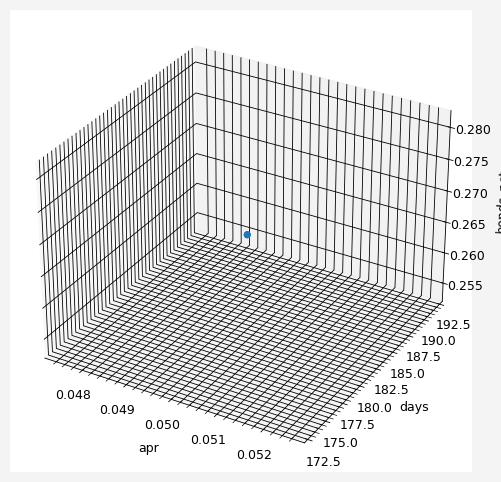

In [ ]:
# plot surface
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['apr'], df['days'], df['bonds_pct'])
ax.set_xlabel('apr')
ax.set_ylabel('days')
ax.set_zlabel('bonds_pct')
plt.show()

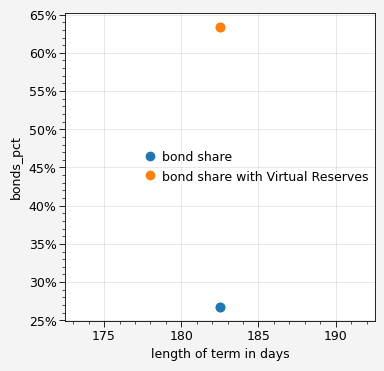

In [ ]:
idx = df['apr'] >= 0
plt.plot(df.loc[idx,'days'], df.loc[idx,'bonds_pct'], 'o', label='bond share')
plt.plot(df.loc[idx,'days'], df.loc[idx,'bonds_pct_with_VL'], 'o', label='bond share with Virtual Reserves')
plt.xlabel('length of term in days')
plt.ylabel('bonds_pct')
# change units to %
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x*100)))
plt.gca().legend()
plt.show()